# <a class="anchor" id="1.5_bullet" style="color:#ef798a"> **Feature Groups creation** </a>
---
In this series of tutorials we will work with data related to NYC taxi fares. The end goal is to train and serve a model on the Hopsworks platform that can predict the trip price.

In this particular notebook you will learn how to:
- Connect to the Hopsworks feature store.
- Create feature groups and upload them to the feature store.

![tutorial-flow](images/online_offline_fs.png)

First of all we will load the data and do some feature engineering on it.


***

### <a class="anchor" id="1.5_bullet" style="color:#e363a3"> **📝 Importing Libraries** </a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2022-07-26 17:14:05,495 INFO: generated new fontManager


In [2]:
import hashlib
from datetime import datetime

In [3]:
# Hops hdfs utility library for reading and writing files from Hopsworks Feature Store

from hops import hdfs

### <a class="anchor" id="1.5_bullet" style="color:#3772ff"> **⬇️ Loading Datasets** </a>

In [4]:
df_rides = pd.read_csv("https://raw.githubusercontent.com/rktraz/NYC-Taxi-Fares-Tutorial/main/rides.csv", 
                       index_col=0, parse_dates=["pickup_datetime"])
df_rides.head(5)

,ride_id,is_start,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id
0,1228,True,1577904560000,0,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194
1,527,True,1577890540000,0,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122
2,394,True,1577887880000,0,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102
3,1366,True,1577907320000,0,-73.860565,40.768370,-73.819430,40.820730,3,2013000059,2013000059
4,1085,True,1577901700000,0,-73.831210,40.805737,-73.782560,40.867650,3,2013000064,2013000064


In [5]:
df_fares = pd.read_csv("https://raw.githubusercontent.com/rktraz/NYC-Taxi-Fares-Tutorial/main/fares.csv", 
                       index_col=0, parse_dates=["pickup_datetime"])
df_fares.head(5)

,ride_id,taxi_id,driver_id,pickup_datetime,payment_type,tip,tolls,total_fare
0,1,2013000185,2013000185,1577880020,CASH,33.0,0.0,118.0
1,2,2013000108,2013000108,1577880040,CARD,14.0,0.0,48.0
2,3,2013000134,2013000134,1577880060,CASH,12.0,0.0,41.0
3,4,2013000062,2013000062,1577880080,CARD,13.0,0.0,44.0
4,5,2013000087,2013000087,1577880100,CASH,14.0,0.0,46.0


## <a class="anchor" id="1.5_bullet" style="color:#df2935"> **🛠 EDA and Feature Engineering** </a>

### <a class="anchor" id="1.5_bullet" style="color:#624763"> **🔬 df_rides** </a>

In [6]:
df_rides.dtypes

ride_id                int64
is_start                bool
pickup_datetime       object
dropoff_datetime       int64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
taxi_id                int64
driver_id              int64
dtype: object

In [7]:
df_rides.pickup_datetime

0        1577904560000
1        1577890540000
2        1577887880000
3        1577907320000
4        1577901700000
             ...      
41073    1578696720000
41074    1578692780000
41075    1578698180000
41076    1578697460000
41077    1578697620000
Name: pickup_datetime, Length: 41078, dtype: object

In [8]:
df_rides.head(3)

,ride_id,is_start,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id
0,1228,True,1577904560000,0,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194
1,527,True,1577890540000,0,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122
2,394,True,1577887880000,0,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102


In [9]:
df_rides.dropoff_datetime.unique(), df_rides.is_start.unique()

(array([0]), array([ True]))

As we can see, 'dropoff_datetime' and 'is_start' columns do not give us any useful info. We will drop them.

In [10]:
df_rides = df_rides.drop(columns=["dropoff_datetime", "is_start"])

In [11]:
df_rides.shape

(41078, 9)

In [12]:
df_rides.describe()

,ride_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id
count,41078.000000,41078.000000,41078.000000,41078.000000,41078.000000,41078.000000,4.107800e+04,4.107800e+04
mean,20539.500000,-73.874513,40.750620,-73.874596,40.750514,2.503238,2.013000e+09,2.013000e+09
std,11858.341516,0.068350,0.086990,0.068332,0.086967,0.513021,5.773362e+01,5.773362e+01
min,1.000000,-74.140670,40.411880,-74.140670,40.411880,1.000000,2.013000e+09,2.013000e+09
25%,10270.250000,-73.921960,40.690235,-73.922005,40.690175,2.000000,2.013000e+09,2.013000e+09
50%,20539.500000,-73.874306,40.750890,-73.874468,40.750676,3.000000,2.013000e+09,2.013000e+09
75%,30808.750000,-73.827060,40.811023,-73.827156,40.810890,3.000000,2.013000e+09,2.013000e+09
max,41078.000000,-73.603760,41.095210,-73.603760,41.095210,4.000000,2.013000e+09,2.013000e+09


#### <a class="anchor" id="1.5_bullet" style="color:#dea402"> **💡 Dealing with distance metrics** </a>


In [13]:
# minimum and maximum longitude
min(df_rides.pickup_longitude.min(), df_rides.dropoff_longitude.min()), \
max(df_rides.pickup_longitude.max(), df_rides.dropoff_longitude.max())

(-74.14067, -73.60376)

In [14]:
# minimum and maximum longitude
min(df_rides.pickup_latitude.min(), df_rides.dropoff_latitude.min()), \
max(df_rides.pickup_latitude.max(), df_rides.dropoff_latitude.max())

(40.41188, 41.09521)

##### <a class="anchor" id="1.5_bullet" style="color:#dea402"> **Let's select rides that were perfomed inside NYC geographically** </a>


In [15]:
# a function for selecting rows that are inside some bounding box
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# NYC coordinates bounding box
BB = (-74.5, -72.8, 40.5, 41.8)

In [16]:
print('Old size: %d' % len(df_rides))
df_rides = df_rides[select_within_boundingbox(df_rides, BB)]
print('New size: %d' % len(df_rides))

Old size: 41078
New size: 40907


##### <a class="anchor" id="1.5_bullet" style="color:#dea402"> **Now we will add a new column that represents distance of rides (in miles).** </a>


In [17]:
# returns distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [18]:
df_rides.columns

Index(['ride_id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'taxi_id',
       'driver_id'],
      dtype='object')

In [19]:
df_rides["distance"] = distance(df_rides["pickup_latitude"], df_rides["pickup_longitude"],
                            df_rides["dropoff_latitude"], df_rides["dropoff_longitude"])

In [20]:
df_rides.head(3)

,ride_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id,distance
0,1228,1577904560000,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194,0.367822
1,527,1577890540000,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122,5.090499
2,394,1577887880000,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102,8.017468


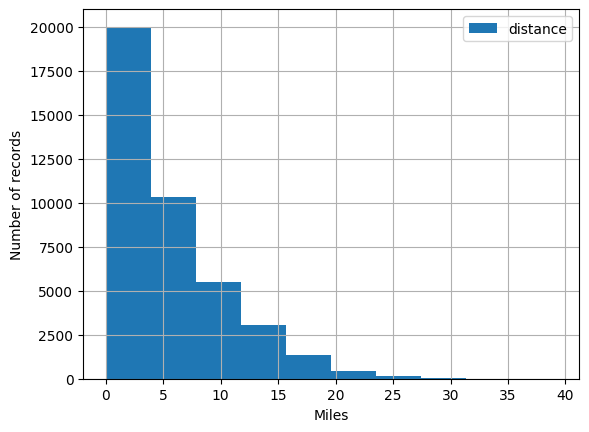

In [21]:
df_rides.distance.hist(legend=True)
plt.xlabel('Miles')
plt.ylabel('Number of records')
plt.show()

##### <a class="anchor" id="1.5_bullet" style="color:#dea402"> **Let us add usefull features about distances to NYC airports.** </a>



In [22]:
# Distances to nearby airports
jfk = (-73.7781, 40.6413)
ewr = (-74.1745, 40.6895)
lgr = (-73.8740, 40.7769)

df_rides['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0],
                                     df_rides['pickup_latitude'], df_rides['pickup_longitude'])
df_rides['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0],
                                       df_rides['dropoff_latitude'], df_rides['dropoff_longitude'])
df_rides['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], 
                                      df_rides['pickup_latitude'], df_rides['pickup_longitude'])
df_rides['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0],
                                       df_rides['dropoff_latitude'], df_rides['dropoff_longitude'])
df_rides['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0],
                                      df_rides['pickup_latitude'], df_rides['pickup_longitude'])
df_rides['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0],
                                       df_rides['dropoff_latitude'], df_rides['dropoff_longitude'])


In [23]:
df_rides.head(3)

,ride_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id,distance,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr
0,1228,1577904560000,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194,0.367822,9.408176,9.593451,16.774843,17.047352,1.258733,1.037595
1,527,1577890540000,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122,5.090499,9.982850,13.547285,17.587239,21.721546,0.929374,5.375477
2,394,1577887880000,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102,8.017468,10.781049,17.111724,18.603343,25.423662,1.764932,9.574572


#### <a class="anchor" id="1.5_bullet" style="color:#ff1053"> **⏱ Dealing with datetime** </a>


##### <a class="anchor" id="1.5_bullet" style="color:#ff1053"> **Now we need to save datetime in the proper format.** </a>


In [24]:
df_rides["pickup_datetime"] = (pd.to_datetime(df_rides["pickup_datetime"],unit='ms'))

##### <a class="anchor" id="1.5_bullet" style="color:#ff1053"> **Adding additional time features.** </a>


In [25]:
df_rides['year'] = df_rides.pickup_datetime.apply(lambda t: t.year)
df_rides['weekday'] = df_rides.pickup_datetime.apply(lambda t: t.weekday())
df_rides['hour'] = df_rides.pickup_datetime.apply(lambda t: t.hour)

##### <a class="anchor" id="1.5_bullet" style="color:#ff1053"> **Make a new `month_of_the_ride` column for *partition_key* (this is all for Feature Group creating).** </a>



In [26]:
df_rides["month_of_the_ride"] = df_rides["pickup_datetime"].dt.strftime('%Y%m')

##### <a class="anchor" id="1.5_bullet" style="color:#ff1053"> **Convert a `pickup_datetime` back to UNIX format.** </a>



In [27]:
df_rides["pickup_datetime"] = df_rides["pickup_datetime"].values.astype(np.int64) // 10 ** 6

In [28]:
df_rides.head(3)

,ride_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id,distance,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,year,weekday,hour,month_of_the_ride
0,1228,1577904560000,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194,0.367822,9.408176,9.593451,16.774843,17.047352,1.258733,1.037595,2020,2,18,202001
1,527,1577890540000,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122,5.090499,9.982850,13.547285,17.587239,21.721546,0.929374,5.375477,2020,2,14,202001
2,394,1577887880000,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102,8.017468,10.781049,17.111724,18.603343,25.423662,1.764932,9.574572,2020,2,14,202001


***

### <a class="anchor" id="1.5_bullet" style="color:#624763"> **🔬 df_fares** </a>

In [29]:
df_fares.head(3)

,ride_id,taxi_id,driver_id,pickup_datetime,payment_type,tip,tolls,total_fare
0,1,2013000185,2013000185,1577880020,CASH,33.0,0.0,118.0
1,2,2013000108,2013000108,1577880040,CARD,14.0,0.0,48.0
2,3,2013000134,2013000134,1577880060,CASH,12.0,0.0,41.0


In [30]:
df_fares.dtypes

ride_id              int64
taxi_id              int64
driver_id            int64
pickup_datetime     object
payment_type        object
tip                float64
tolls              float64
total_fare         float64
dtype: object

In [31]:
df_rides.shape

(40907, 20)

In [32]:
df_fares.shape

(41078, 8)

#### <a class="anchor" id="1.5_bullet" style="color:#ff1053"> **⏱ Dealing with datetime** </a>


##### <a class="anchor" id="1.5_bullet" style="color:#ff1053"> **Converting datetime column to the proper format.** </a>



In [33]:
df_fares["pickup_datetime"] = pd.to_datetime(df_fares["pickup_datetime"].apply(lambda x: str(x) + "000"),
                                             unit='ms')

##### <a class="anchor" id="1.5_bullet" style="color:#ff1053"> **Make a new `month_of_the_ride` column for *partition_key* (this is all for Feature Group creating)** </a>



In [34]:
df_fares["month_of_the_ride"] = df_fares["pickup_datetime"].dt.strftime('%Y%m')

##### <a class="anchor" id="1.5_bullet" style="color:#ff1053"> **Convert a `pickup_datetime` back to UNIX format.** </a>



In [35]:
df_fares["pickup_datetime"] = df_fares["pickup_datetime"].values.astype(np.int64) // 10 ** 6

In [36]:
df_fares.head(3)

,ride_id,taxi_id,driver_id,pickup_datetime,payment_type,tip,tolls,total_fare,month_of_the_ride
0,1,2013000185,2013000185,1577880020000,CASH,33.0,0.0,118.0,202001
1,2,2013000108,2013000108,1577880040000,CARD,14.0,0.0,48.0,202001
2,3,2013000134,2013000134,1577880060000,CASH,12.0,0.0,41.0,202001


Droping useless features.

In [37]:
df_fares.payment_type.unique()

array(['CASH', 'CARD'], dtype=object)

In [38]:
df_fares = df_fares.drop(columns=["payment_type"])

In [39]:
df_fares.head(3)

,ride_id,taxi_id,driver_id,pickup_datetime,tip,tolls,total_fare,month_of_the_ride
0,1,2013000185,2013000185,1577880020000,33.0,0.0,118.0,202001
1,2,2013000108,2013000108,1577880040000,14.0,0.0,48.0,202001
2,3,2013000134,2013000134,1577880060000,12.0,0.0,41.0,202001


In [40]:
df_fares.describe()

,ride_id,taxi_id,driver_id,pickup_datetime,tip,tolls,total_fare
count,41078.000000,4.107800e+04,4.107800e+04,4.107800e+04,41078.000000,41078.000000,41078.000000
mean,20539.500000,2.013000e+09,2.013000e+09,1.578291e+12,16.155363,0.250426,59.510030
std,11858.341516,5.773362e+01,5.773362e+01,2.371668e+08,10.901697,0.782238,37.489159
min,1.000000,2.013000e+09,2.013000e+09,1.577880e+12,0.000000,0.000000,3.000000
25%,10270.250000,2.013000e+09,2.013000e+09,1.578085e+12,7.000000,0.000000,29.000000
50%,20539.500000,2.013000e+09,2.013000e+09,1.578291e+12,15.000000,0.000000,54.000000
75%,30808.750000,2.013000e+09,2.013000e+09,1.578496e+12,23.000000,0.000000,83.000000
max,41078.000000,2.013000e+09,2.013000e+09,1.578702e+12,60.000000,5.000000,218.000000


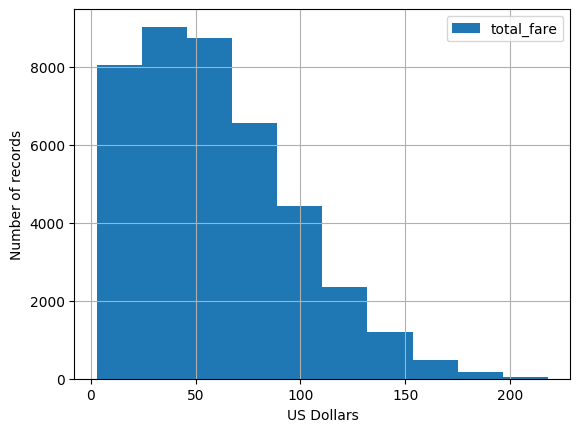

In [41]:
df_fares.total_fare.hist(legend=True)
plt.xlabel('US Dollars')
plt.ylabel('Number of records')
plt.show()

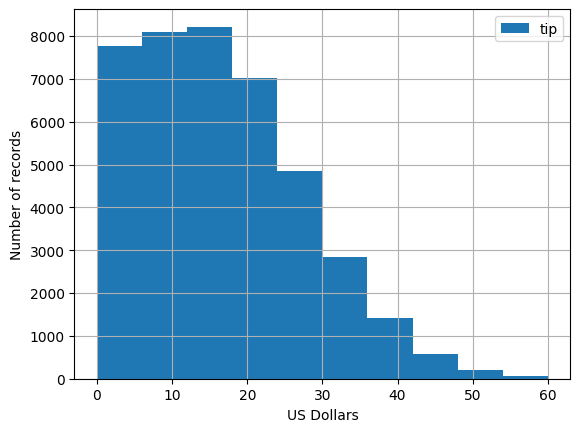

In [42]:
df_fares.tip.hist(legend=True)
plt.xlabel('US Dollars')
plt.ylabel('Number of records')
plt.show()

***

## <a class="anchor" id="1.5_bullet" style="color:#2db3f0"> **🗳 Register feature groups** </a>


### <a class="anchor" id="1.5_bullet" style="color:#2db3f0"> **Instantiate a connection and get the `project` feature store handler** </a>



In [43]:
import hsfs
# from hsfs.rule import Rule

# Create a connection
connection = hsfs.connection()

# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.


#### <a class="anchor" id="1.5_bullet" style="color:#2db3f0"> **Data Validation** </a>

Before we define [feature groups](https://docs.hopsworks.ai/latest/generated/feature_group/) lets define [validation rules](https://docs.hopsworks.ai/latest/generated/feature_validation/) for features. We do expect some of the features to comply with certain *rules* or *expectations*. For example: a transacted amount must be a positive value. In the case of a transacted amount arriving as a negative value we can decide whether to stop it from `write` into a feature group and throw an error or allow it to be written but provide a warning. In the next section we will create feature store `expectations`, attach them to feature groups, and apply them to dataframes being appended to said feature group.

#### <a class="anchor" id="1.5_bullet" style="color:#2db3f0"> **Data validation rules supported in Hopsworks** </a>

Hopsworks comes shipped with a set of data validation rules. These rules are **immutable**, uniquely identified by **name** and are available across all feature stores. These rules are used to create feature store expectations which can then be attached to individual feature groups.

In [44]:
# # Get all rule definitions available in Hopsworks
# rules = connection.get_rules()
# [print(rule.to_dict()) for rule in rules]

In [45]:
# # Get a rule definition by name
# is_positive = connection.get_rule("IS_POSITIVE")
# print(is_positive.to_dict())

### <a class="anchor" id="1.5_bullet" style="color:#772f1a"> **〰️ Create Expectations based on Hopsworks rules** </a>

Expectations are created at the feature store level. Multiple expectations can be created per feature store.
An expectation consist of one or multiple rules and can refer to one or multiple features. An expectation can be utilized by attaching it to a feature group, as shown below.

In [46]:
# expectation_payments = fs.create_expectation("payments",
#                                            features=["totalFare", "tip"], 
#                                            description="validate totalFare and tips correctness",
#                                            rules=[Rule(name="IS_POSITIVE", level="ERROR", max=10000000)])
# expectation_payments.save()

### <a class="anchor" id="1.5_bullet" style="color:#2db3f0"> **Creating Feature Groups** </a>



> ####  a. Create fares feature group metadata and save it to hsfs (Hopsworks Feature Store).
We are going to create time travel enabled feature groups. For this hopsworks uses Apache Hudi. By default, Hudi tends to over-partition input. 

In [47]:
df_fares.head(3)

,ride_id,taxi_id,driver_id,pickup_datetime,tip,tolls,total_fare,month_of_the_ride
0,1,2013000185,2013000185,1577880020000,33.0,0.0,118.0,202001
1,2,2013000108,2013000108,1577880040000,14.0,0.0,48.0,202001
2,3,2013000134,2013000134,1577880060000,12.0,0.0,41.0,202001


In [48]:
df_fares.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41078 entries, 0 to 41077
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ride_id            41078 non-null  int64  
 1   taxi_id            41078 non-null  int64  
 2   driver_id          41078 non-null  int64  
 3   pickup_datetime    41078 non-null  int64  
 4   tip                41078 non-null  float64
 5   tolls              41078 non-null  float64
 6   total_fare         41078 non-null  float64
 7   month_of_the_ride  41078 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 2.8+ MB


In [49]:
fares_fg = fs.get_or_create_feature_group(name="fares_fg",
                                          version=1,
                                          primary_key=["ride_id"],
                                          event_time=["pickup_datetime"],
                                          partition_key=["month_of_the_ride"],   
                                          description="Taxi fares features",
                                          time_travel_format="HUDI",  
                                          online_enabled=True,  
#                                         validation_type="STRICT",
#                                         expectations= [expectation_payments],
                                          statistics_config={
                                              "enabled": False, "histograms": False,
                                              "correlations": False, "exact_uniqueness": False
                                          })   
fares_fg.insert(df_fares)

Feature Group created successfully, explore it at 
https://0f060790-06a4-11ed-8aed-d1422d4ec537.cloud.hopsworks.ai/p/2170/fs/2118/fg/2073


Uploading Dataframe: 0.00% |          | Rows 0/41078 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://0f060790-06a4-11ed-8aed-d1422d4ec537.cloud.hopsworks.ai/p/2170/jobs/named/fares_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fca38428b50>, None)

> #### b. Create rides feature group and save it to hsfs.

In [50]:
df_rides.head(3)

,ride_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,taxi_id,driver_id,distance,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,year,weekday,hour,month_of_the_ride
0,1228,1577904560000,-73.867676,40.759323,-73.864080,40.763897,3,2013000194,2013000194,0.367822,9.408176,9.593451,16.774843,17.047352,1.258733,1.037595,2020,2,18,202001
1,527,1577890540000,-73.857086,40.772793,-73.807335,40.836117,3,2013000122,2013000122,5.090499,9.982850,13.547285,17.587239,21.721546,0.929374,5.375477,2020,2,14,202001
2,394,1577887880000,-73.844320,40.789043,-73.765950,40.888790,3,2013000102,2013000102,8.017468,10.781049,17.111724,18.603343,25.423662,1.764932,9.574572,2020,2,14,202001


In [51]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40907 entries, 0 to 41077
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ride_id                  40907 non-null  int64  
 1   pickup_datetime          40907 non-null  int64  
 2   pickup_longitude         40907 non-null  float64
 3   pickup_latitude          40907 non-null  float64
 4   dropoff_longitude        40907 non-null  float64
 5   dropoff_latitude         40907 non-null  float64
 6   passenger_count          40907 non-null  int64  
 7   taxi_id                  40907 non-null  int64  
 8   driver_id                40907 non-null  int64  
 9   distance                 40907 non-null  float64
 10  pickup_distance_to_jfk   40907 non-null  float64
 11  dropoff_distance_to_jfk  40907 non-null  float64
 12  pickup_distance_to_ewr   40907 non-null  float64
 13  dropoff_distance_to_ewr  40907 non-null  float64
 14  pickup_distance_to_lgr

In [52]:
rides_fg = fs.get_or_create_feature_group(name="rides_fg",
                                   version=1,
                                   primary_key=["ride_id"],
                                   event_time=["pickup_datetime"],                                   
                                   partition_key=["month_of_the_ride"],         
                                   description="Rides features",
                                   time_travel_format="HUDI",     
                                   online_enabled=True,                                                
                                   statistics_config={"enabled": False, "histograms": False, "correlations": False, "exact_uniqueness": False})   
rides_fg.insert(df_rides)

Feature Group created successfully, explore it at 
https://0f060790-06a4-11ed-8aed-d1422d4ec537.cloud.hopsworks.ai/p/2170/fs/2118/fg/2074


Uploading Dataframe: 0.00% |          | Rows 0/40907 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://0f060790-06a4-11ed-8aed-d1422d4ec537.cloud.hopsworks.ai/p/2170/jobs/named/rides_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fca365e18b0>, None)

---
**NOTE**:

All of the above UI functionality is also available via hsfs API. For more details please refer to the [Hopsworks Feature Store documentation.](https://docs.hopsworks.ai/latest/generated/feature_store/)

---


### Next Steps

In the next notebook we will use our feature groups to create a dataset we can train a model on.